In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

train_data.info()

train_data.shape[0]
#there is one image for each row, so there are 42000 images in the train dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


42000

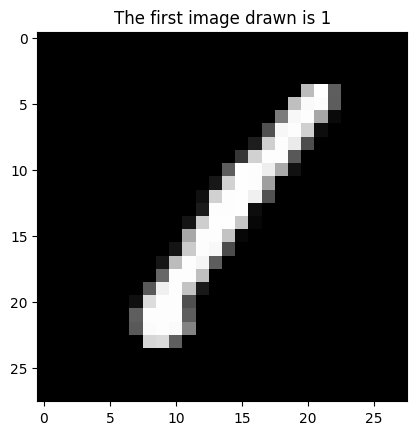

In [4]:
# Select the first image (excluding the label column)
sample_image = train_data.iloc[0, 1:].values  
# Take all columns and reshape to 28x28 matrix
sample_image = sample_image.reshape(28, 28)  

# Plot the image by mapping each pixel value to a corresponding color on a grayscale.
# Lower value = darker color.
plt.imshow(sample_image, cmap='gray')
plt.title(f"The first image drawn is {train_data.iloc[0, 0]}")
plt.show()

In [5]:
rotation_data_augmentation = 45
batch_size = 128
num_epochs = 10
learning_rate = 0.001

In [6]:
# Implementing data augmentation

# Extract images and labels
labels = torch.tensor(train_data.iloc[:, 0].values, dtype=torch.long)  # First column is labels
images = train_data.iloc[:, 1:].values.reshape(-1, 1, 28, 28).astype(np.uint8)/255.0  # Reshape images to (N, 1, 28, 28)
images = torch.tensor(images, dtype=torch.float32)  # Convert to PyTorch tensor

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=rotation_data_augmentation),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomHorizontalFlip(),
    #transforms.Normalize((0.5,), (0.5,))
])

# We don't want to augment the validation set
val_transform = transforms.Compose([
    #transforms.Normalize((0.5,), (0.5,))  # No augmentation for validation
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)  # Apply transformation
        return image, self.labels[idx]

# Create dataset with augmentation
# train_dataset = AugmentedDataset(images, labels, transform=train_transform)
# From the 42000 training examples we create batches of size 64. After each epoch (once we train the model once through all examples)
# The new epoch will see randomly rotation images from the train dataset. 
#train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

full_dataset = AugmentedDataset(images, labels, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 33600, Validation samples: 8400


In [7]:
# We now create a class which inherits the properties of nn.Module.
# This class will define the layers and operations the model will use.

class DigitModel(nn.Module):
    def __init__(self):
        super(DigitModel, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*3*3, 128)  
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        #self.dropout2 = nn.Dropout(0.3)
        #self.fc3 = nn.Linear(84, 10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        #x = self.global_avg_pool(x)  
        #x = torch.flatten(x, start_dim=1)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        #x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        #x = self.fc3(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DigitModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

def evaluate(model, val_loader, criterion):
    model.eval()  # Set model to evaluation mode (disables dropout & batch norm updates)
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation for validation (faster & saves memory)
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)  # Compute average loss
    val_acc = 100 * correct / total  # Compute accuracy
    return val_loss, val_acc

In [9]:
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move batch to GPU

        optimizer.zero_grad()
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/10] - Train Loss: 0.2496, Train Acc: 92.48% | Val Loss: 0.0535, Val Acc: 98.21%
Epoch [2/10] - Train Loss: 0.0875, Train Acc: 97.49% | Val Loss: 0.0633, Val Acc: 98.05%
Epoch [3/10] - Train Loss: 0.0545, Train Acc: 98.49% | Val Loss: 0.0306, Val Acc: 99.11%
Epoch [4/10] - Train Loss: 0.0520, Train Acc: 98.56% | Val Loss: 0.0358, Val Acc: 98.92%
Epoch [5/10] - Train Loss: 0.0338, Train Acc: 99.07% | Val Loss: 0.0324, Val Acc: 98.96%
Epoch [6/10] - Train Loss: 0.0292, Train Acc: 99.26% | Val Loss: 0.0230, Val Acc: 99.21%
Epoch [7/10] - Train Loss: 0.0246, Train Acc: 99.35% | Val Loss: 0.0250, Val Acc: 99.19%
Epoch [8/10] - Train Loss: 0.0218, Train Acc: 99.42% | Val Loss: 0.0244, Val Acc: 99.25%
Epoch [9/10] - Train Loss: 0.0182, Train Acc: 99.60% | Val Loss: 0.0225, Val Acc: 99.27%
Epoch [10/10] - Train Loss: 0.0154, Train Acc: 99.66% | Val Loss: 0.0230, Val Acc: 99.33%


In [10]:
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test_images = torch.tensor(test_data.values.reshape(-1, 1, 28, 28), dtype=torch.float32)/255.0
test_loader = DataLoader(test_images, batch_size=64, shuffle=False)

model.eval()  # Set model to evaluation mode
predictions = []

with torch.no_grad():  # No gradients needed during inference
    for images in test_loader:
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        predictions.extend(predicted.cpu().numpy())  # Store predictions

submission = pd.DataFrame({'ImageId': np.arange(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


# 